In [1]:
import tensorflow as tf

import scipy

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf "sample_data/" "kfood50_imageSet/" # 파일 삭제하는 커맨드이므로 주의할 것!

In [ ]:
!unzip "/content/drive/MyDrive/AI_images/kfood50_imageSet.zip"

In [20]:
imgSet_path = 'kfood50_imageSet/'
train_path = imgSet_path + 'train/'
valid_path = imgSet_path + 'validation/'
test_path = imgSet_path + 'test/'

img_height = 224
img_width = 224
batch_size = 64;
# batch_size_train = 750
# batch_size_validation = 150
# batch_size_test = 100

In [21]:
# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

In [22]:
datagen = ImageDataGenerator(rescale=1./ 255)

train_generator = datagen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = datagen.flow_from_directory(
    valid_path,
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_path,
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 37500 images belonging to 50 classes.
Found 7500 images belonging to 50 classes.
Found 5000 images belonging to 50 classes.


In [23]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D 
from keras.layers import BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam

num_classes = 50 # 음식 종류 50가지

def create_model() :

    # MobileNet 모델 가져오기 (가중치는 'imagenet' 사용)
    base_model = MobileNetV2(weights='imagenet', include_top=False, 
                           input_shape=(224, 224, 3))

    # 모델 아키텍처에 맞게 새로운 분류 레이어 추가하기
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # 전체 모델 구성
    model = Model(inputs=base_model.input, outputs=output)

    # 기존 가중치 동결
    for layer in base_model.layers:
        layer.trainable = False

    # 모델 컴파일
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
model = create_model()
#model.summary()

In [25]:
from datetime import datetime

now = datetime.now()
print("시작 시간 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

시작 시간 :  2023-05-17 05:13:34


In [ ]:
history = model.fit(
    train_generator,  # 학습 데이터 제네레이터
    epochs=10,  # 학습 에포크 수
    verbose=1,
    validation_data=valid_generator,  # 검증 데이터 제네레이터
)

Epoch 1/10
586/586 [==============================] - 304s 512ms/step - loss: 1.5433 - accuracy: 0.5600 - val_loss: 1.2850 - val_accuracy: 0.6304
Epoch 2/10
586/586 [==============================] - 305s 521ms/step - loss: 1.0746 - accuracy: 0.6733 - val_loss: 1.3348 - val_accuracy: 0.6235
Epoch 3/10
586/586 [==============================] - 297s 507ms/step - loss: 0.9378 - accuracy: 0.7126 - val_loss: 1.2650 - val_accuracy: 0.6443
Epoch 4/10
586/586 [==============================] - 292s 498ms/step - loss: 0.8465 - accuracy: 0.7346 - val_loss: 1.3070 - val_accuracy: 0.6333
Epoch 5/10
 16/586 [..............................] - ETA: 4:08 - loss: 0.7062 - accuracy: 0.7744

In [ ]:
#from datetime import datetime

after = datetime.now()
print("완료 시간 : ", after.strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
modelFile = 'mobileNet-32-10.h5'
model.save(modelFile)

!cp $modelFile /content/drive/MyDrive/Models/$modelFile

In [ ]:
# 5 epochs 추가 학습
model.fit_generator(
    train_generator,  # 학습 데이터 제네레이터
    steps_per_epoch=len(train_generator),  # 에포크 당 스텝 수
    epochs=5,  # 학습 에포크 수
    validation_data=valid_generator,  # 검증 데이터 제네레이터
    validation_steps=len(valid_generator)  # 검증 스텝 수
)

<ipython-input-22-b4d18b3cad92>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
1172/1172 [==============================] - 265s 226ms/step - loss: 0.6555 - accuracy: 0.7897 - val_loss: 1.2622 - val_accuracy: 0.6647
Epoch 2/5
1172/1172 [==============================] - 263s 225ms/step - loss: 0.6363 - accuracy: 0.7971 - val_loss: 1.3115 - val_accuracy: 0.6523
Epoch 3/5
1172/1172 [==============================] - 263s 225ms/step - loss: 0.6186 - accuracy: 0.8028 - val_loss: 1.3142 - val_accuracy: 0.6541
Epoch 4/5
1172/1172 [==============================] - 264s 225ms/step - loss: 0.6020 - accuracy: 0.8042 - val_loss: 1.3338 - val_accuracy: 0.6544
Epoch 5/5
1172/1172 [==============================] - 267s 228ms/step - loss: 0.5892 - accuracy: 0.8083 - val_loss: 1.3057 - val_accuracy: 0.6675


In [ ]:
modelFile = 'mobileNet-32-15.h5'
model.save(modelFile)

!cp $modelFile /content/drive/MyDrive/Models/$modelFile

In [ ]:
# 예측 결과 얻기
predictions = model.predict(test_generator)

# 예측 결과 출력
predicted_labels = np.argmax(predictions, axis=1)  # 가장 높은 확률을 가진 클래스의 인덱스 추출
class_labels = list(test_generator.class_indices.keys())  # 클래스 라벨 목록
for i, label_idx in enumerate(predicted_labels):
    label = class_labels[label_idx]
    print(f"Image {i+1}: Predicted label - {label}")

<ipython-input-24-a03fe093dffe>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


Image 1: Predicted label - 김치볶음밥
Image 2: Predicted label - 쫄면
Image 3: Predicted label - 새우튀김
Image 4: Predicted label - 달걀국
Image 5: Predicted label - 오징어튀김
Image 6: Predicted label - 시금치나물무침
Image 7: Predicted label - 시래기된장국
Image 8: Predicted label - 숙주나물무침
Image 9: Predicted label - 고사리나물무침
Image 10: Predicted label - 삼겹살구이
Image 11: Predicted label - 소세지볶음
Image 12: Predicted label - 애호박볶음
Image 13: Predicted label - 삼겹살구이
Image 14: Predicted label - 갈비탕
Image 15: Predicted label - 떡볶이
Image 16: Predicted label - 알밥
Image 17: Predicted label - 북엇국
Image 18: Predicted label - 오징어튀김
Image 19: Predicted label - 시래기된장국
Image 20: Predicted label - 감자조림
Image 21: Predicted label - 쫄면
Image 22: Predicted label - 소고기무국
Image 23: Predicted label - 삼계탕
Image 24: Predicted label - 김치찌개
Image 25: Predicted label - 오징어튀김
Image 26: Predicted label - 애호박볶음
Image 27: Predicted label - 고사리나물무침
Image 28: Predicted l

In [ ]:
# 가중치와 옵티마이저를 포함하여 정확히 동일한 모델을 다시 생성합니다
modelFile = 'mobileNet-32-10.h5'
new_model = tf.keras.models.load_model(modelFile)

loss, acc = new_model.evaluate(test_generator, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))

157/157 - 40s - loss: 1.0956 - accuracy: 0.7000 - 40s/epoch - 253ms/step
복원된 모델의 정확도: 70.00%


In [ ]:
# 가중치와 옵티마이저를 포함하여 정확히 동일한 모델을 다시 생성합니다
modelFile = 'mobileNet-32-15.h5'
new_model = tf.keras.models.load_model(modelFile)

loss, acc = new_model.evaluate(test_generator, verbose=2)
print('복원된 모델의 정확도: {:5.2f}%'.format(100*acc))

157/157 - 44s - loss: 1.0697 - accuracy: 0.7156 - 44s/epoch - 283ms/step
복원된 모델의 정확도: 71.56%


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

modelFile = 'mobileNet-32-15.h5'
model = tf.keras.models.load_model(modelFile)

class_labels = list(test_generator.class_indices.keys())
test_results = np.argmax(model.predict(test_generator),axis=1)
test_labels = np.array(test_generator.labels)
print(test_results.shape, test_labels.shape)

157/157 [==============================] - 38s 240ms/step
(5000,) (5000,)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4449 (\N{HANGUL JUNGSEONG A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4357 (\N{HANGUL CHOSEONG RIEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

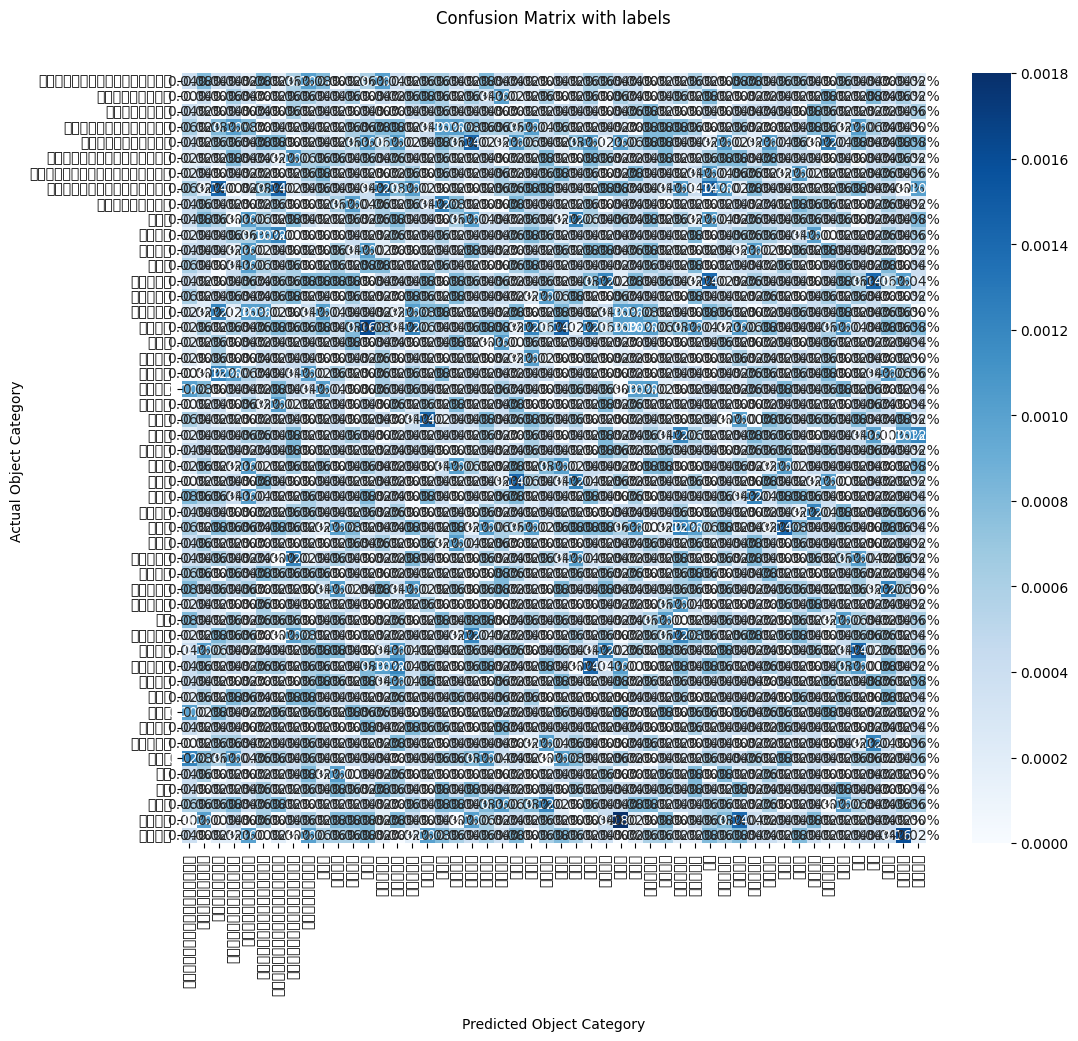


Accuracy: 0.02



In [ ]:
cf_matrix = confusion_matrix(test_results, test_labels)

plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%',cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Object Category')
ax.set_ylabel('Actual Object Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

## Display the visualization of the Confusion Matrix.
plt.show()

accuracy = np.trace(cf_matrix)/len(test_labels)
print('\nAccuracy: {:.2f}\n'.format(accuracy))